In [1]:
import numpy as np
import pylab as pl
%matplotlib inline

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'    

In [3]:
# Setting velocity and spatial grid points
N_positions = 100
ghost_zones = 3
N_velocity  = 1000

In [4]:
# Boundaries of domain
left_boundary  = 0
right_boundary = 1.0
length         = right_boundary - left_boundary

In [5]:
# Setting mass of the particle, boltzmann-constant
mass_particle      = 1.0
boltzmann_constant = 1.0

In [6]:
# Scattering time scale
tau   = 1.0
# Magnitude of maximum velocity
v_max = 10

In [7]:
# Time Parameters for the simulation:
dt         = 0.001 # Size of the time-step
final_time = 5.0
time       = np.arange(dt, final_time, dt)

In [8]:
# Setting up the temperature parameters for the simulations:
T_initial = 1.5
T_walls   = 2.0

In [9]:
# Setting up of spatial and velocity grids:
x  = np.linspace(left_boundary, right_boundary, N_positions)
dx = x[1] - x[0]

# Obtaining the coordinates for the ghost-zones:
x_ghost_left  = np.linspace(-(ghost_zones)*dx + left_boundary, left_boundary - dx, ghost_zones)
x_ghost_right = np.linspace(right_boundary + dx, right_boundary + ghost_zones*dx , ghost_zones)

# Combining them to obtain the entire spatial grid
x  = np.concatenate([x_ghost_left, x, x_ghost_right])

# Obtaining the velocity grid
v  = np.linspace(-v_max, v_max, N_velocity)

In [10]:
# Conversion to allow for easy vectorization
x = x * np.ones([N_velocity , N_positions + 2*ghost_zones])
v = v * np.ones([N_positions + 2*ghost_zones, N_velocity])
v = np.transpose(v)

In [11]:
def calculate_density(f, v):
    deltav           = v[1, 0]-v[0, 0]
    value_of_density = np.sum(f, axis = 0)*deltav
    return(value_of_density)

In [12]:
def calculate_temperature(f, v):
    deltav               = v[1, 0]-v[0, 0]
    value_of_temperature = np.sum(f*v**2, axis = 0)*deltav
    return(value_of_temperature)

In [13]:
def f_MB(x, v, f):
    n = calculate_n(f, v) * np.ones((N_velocity, N_positions + 2*ghost_zones), dtype = np.float)
    T = calculate_T(f, v) * np.ones((N_velocity, N_positions + 2*ghost_zones), dtype = np.float)
    f_MB = n*np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T))*\
           np.exp(-mass_particle*v**2/(2*boltzmann_constant*T))
    return(f_MB)

In [14]:
# Function that return's the distribution function at the walls.
def f_walls(v):
    f_walls = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_walls))*\
              np.exp(-mass_particle*v**2/(2*boltzmann_constant*T_walls))
    return(f_walls)

In [15]:
def f_interp(dt, x, v, f):
    x_new     = x - v*dt
    f_interp  = np.zeros([N_velocity, N_positions + 2*ghost_zones])
    f_interp  = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_walls)) * \
                np.exp(-mass_particle*v**2/(2*boltzmann_constant*T_walls))

    for i in range(N_velocity):
        wall_indices = np.where(  (x_new[i, ghost_zones:-ghost_zones]<=left_boundary) \
                                + (x_new[i, ghost_zones:-ghost_zones]>=right_boundary) \
                               )[0]

        f_interp[i, ghost_zones:-ghost_zones]   = np.interp(x_new[i, ghost_zones:-ghost_zones], x[i, :], f[i, :])
        f_interp[i, wall_indices + ghost_zones] = f_walls(v[:, 0])[i]
    return f_interp

In [16]:
# Intializing the values for f
f_initial = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_initial)) * \
            np.exp(-mass_particle*v**2/(2*boltzmann_constant*T_initial))

# Declaring the indices of the ghost cells at the left and right walls
indices_left  = np.arange(ghost_zones)
indices_right = np.arange(N_positions + 1, N_positions + ghost_zones + 1)
indices_walls = np.concatenate([indices_left, indices_right])

# Setting temperature at the walls:
for i in indices_walls:
    f_initial[:, i] = np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_walls)) * \
                      np.exp(-mass_particle*v[:, 0]**2/(2*boltzmann_constant*T_walls))

f_current = f_initial

In [17]:
fstar = f_interp(dt, x, v, f_current)

In [18]:
fstar

array([[  3.91771663e-12,   3.91771663e-12,   3.91771663e-12, ...,
          3.91771663e-12,   3.91771663e-12,   3.91771663e-12],
       [  4.32974605e-12,   4.32974605e-12,   4.32974605e-12, ...,
          4.32974605e-12,   4.32974605e-12,   4.32974605e-12],
       [  4.78415010e-12,   4.78415010e-12,   4.78415010e-12, ...,
          4.78415010e-12,   4.78415010e-12,   4.78415010e-12],
       ..., 
       [  4.78415010e-12,   4.78415010e-12,   4.78415010e-12, ...,
          4.78415010e-12,   4.78415010e-12,   4.78415010e-12],
       [  4.32974605e-12,   4.32974605e-12,   4.32974605e-12, ...,
          4.32974605e-12,   4.32974605e-12,   4.32974605e-12],
       [  3.91771663e-12,   3.91771663e-12,   3.91771663e-12, ...,
          3.91771663e-12,   3.91771663e-12,   3.91771663e-12]])

In [19]:
# Now we shall do the analytical calculations for the same:

In [20]:
def initial_density(x):
    return 1.000

initial_density = np.vectorize(initial_density)

In [27]:
def initial_temperature(x):
    if(x<=left_boundary or x>=right_boundary):
        return T_walls
    
    else:
        return T_initial

initial_temperature = np.vectorize(initial_temperature)

In [28]:
def f_MB_analytical(x, v):
    f_MB_analytical = initial_density(x)*np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*initial_temperature(x)))*\
                      np.exp(-mass_particle*v**2/(2*boltzmann_constant*initial_temperature(x)))
    return(f_MB_analytical)

f_MB_analytical = np.vectorize(f_MB_analytical)

In [29]:
f0 = f_MB_analytical(x - v*dt, v)

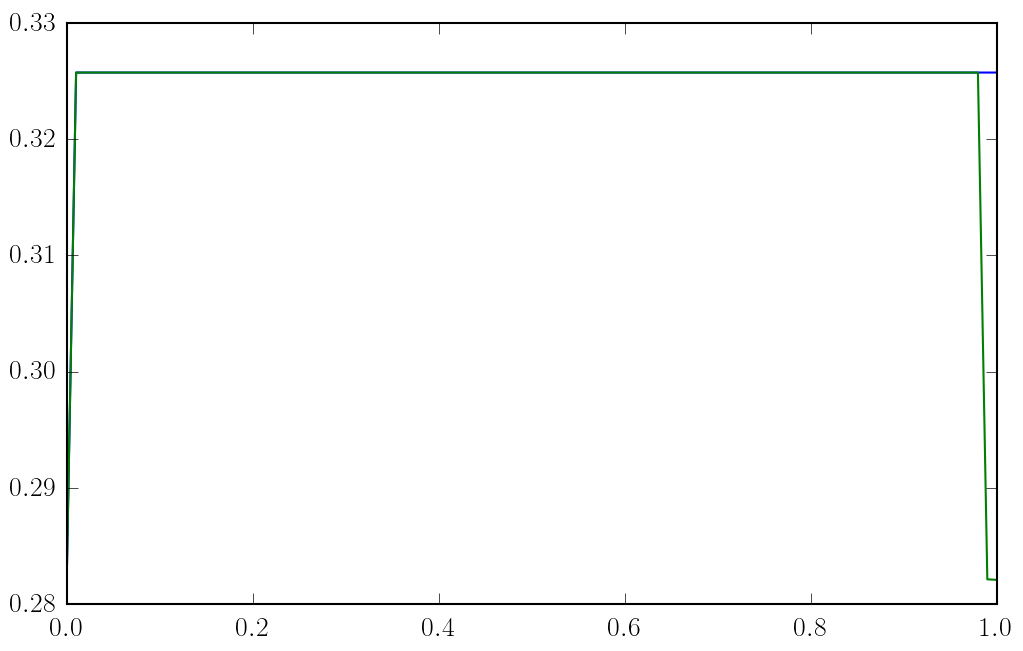

In [31]:
pl.plot(x[0,ghost_zones:-ghost_zones], f0[500,ghost_zones:-ghost_zones])
pl.plot(x[0,ghost_zones:-ghost_zones], fstar[500,ghost_zones:-ghost_zones])

In [48]:
fstar[500,:]

array([ 0.28208773,  0.28208773,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32

In [49]:
f0[500,ghost_zones:-ghost_zones]

array([ 0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32572413,
        0.32572413,  0.32572413,  0.32572413,  0.32572413,  0.32

In [2]:
from scipy.interpolate import interp1d

In [3]:
interp1d?